# Análisis de datos Experimento 1
Con 10% de hábitat en el paisaje, 10 niveles de intensificación y 100 comunidades.
Riqueza y biomasa total.

In [1]:
import numpy as np
import seaborn, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats

In [2]:
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)
plt.style.use('seaborn-whitegrid')
seaborn.set_palette("deep", color_codes=True)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (9, 7)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [3]:
%run ../medidas_biodiversidad.py

## Funciones para leer datos

In [201]:
def leer_datos(het):
    files = os.listdir("../datos/exp1b")
    files.sort()
    files = list(filter(lambda x: x[7] == het, files))
    
    datos = [np.load("../datos/exp1b/" + file) for file in files]
    comunidad = [file[10:13] for file in files]
    
    return datos, comunidad

In [5]:
def calcular_medida(medida, datos, paisajes, bio_min = 5.):
    medidas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            medidas[comunidad, intensificacion] = medida(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return medidas

In [6]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))

    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion], riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return biomasas, riquezas

In [62]:
def calcular_riquezatotal(datos, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))
    
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion], riquezas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-1, biomasa_min = bio_min)
    return biomasas, riquezas

In [172]:
def calcular_riquezatotal_adaptable(datos, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))
    
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-2, biomasa_min = bio_min)[0]
            
            umbral = biomasas[comunidad, 0] / 20
            riquezas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-2, biomasa_min = umbral)[1]
    return biomasas, riquezas

In [8]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    median = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[:, i])
        std[i] = np.std(riquezas[:, i])
        median[i] = np.median(riquezas[:, i])
    return promedios, std, median

In [9]:
def abundancia_promedio(poblacion, umbral_supervivencia):
    """ Calcula la riqueza de acuerdo a la cantidad de especies cuya abundancia promedio
    en las últimas seis iteraciones es mayor a cierto umbral de supervivencia.
        Entrada: un arreglo poblacion con la forma poblacion[tiempo, x, y, especies], umbral de supervivencia
        Salida: 
    """
    riqueza = []
    for especie in range(poblacion.shape[3]):
        if np.sum(poblacion[1:6,:,:,especie])/6 > umbral_supervivencia: #abundancia promedio en últimas 6 iteraciones
            riqueza.append(1) 

    return np.sum(riqueza)  #riqueza de especies

In [10]:
def calcular_abundancia_promedio(datos, bio_min):
    riquezas = np.zeros((100, 10))
    
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = abundancia_promedio(
                                                    datos[comunidad][intensificacion],
                                                    umbral_supervivencia = bio_min)
    return riquezas

In [83]:
def mean_species_abundance(poblaciones):
    abundancia = np.zeros((10, 10))
    msa = np.zeros(10)
    for i in range(10):
        for especie in range(10):
            abundancia[i, especie] = np.sum(poblaciones[i,-3,:,:,especie])
    
    for i in range(10):
        relative_abundance = abundancia[i] / abundancia[0]
        relative_abundance[relative_abundance>1] = 1
        relative_abundance[relative_abundance<0] = 0

        msa[i] = np.mean(relative_abundance)        
    
    return msa

In [12]:
def calcular_msa(datos):
    msa = np.zeros((100, 10))
    
    for comunidad in range(len(datos)):
        msa[comunidad] = mean_species_abundance(datos[comunidad])
    
    return msa

## Leer datos, calcular promedios, sd

In [9]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("../paisajes_h{}.npy".format(het))

In [203]:
#datos = [None] * 5
riquezas = [None] * 5
biomasas = [None] * 5
riqueza_total = [None] * 5
biomasa_total = [None] * 5

'''
riquezas_mean = [None] * 5
riquezas_sd = [None] * 5
riquezas_median = [None] * 5

biomasas_mean = [None] * 5
biomasas_sd = [None] * 5
biomasas_median = [None] * 5

area = [None] * 5
area_mean = [None] * 5
area_sd = [None] * 5
area_median = [None] * 5
'''
riqueza_total_mean = [None] * 5
riqueza_total_sd = [None] * 5
riqueza_total_median = [None] * 5

biomasa_total_mean = [None] * 5
biomasa_total_sd = [None] * 5
biomasa_total_median = [None] * 5


for het in range(5):
    #datos[het] = leer_datos(str(het))[0]
    
    #biomasas[het], riquezas[het] = calcular_riqueza(datos[het], paisajes[het], bio_min = 30)
    #biomasa_total[het], riqueza_total[het] = calcular_riquezatotal(datos[het], bio_min = 30)
    biomasa_total[het], riqueza_total[het] = calcular_riquezatotal(datos[het], bio_min = 30)

    #riqueza_total[het] = calcular_msa(datos[het])
    
    
    #riquezas_mean[het], riquezas_sd[het], riquezas_median[het] = calcular_promedio(riquezas[het])

    #area[het] = calcular_medida(medida_area,  datos[het], paisajes[het], bio_min = 15)
    #area_mean[het], area_sd[het], area_median[het] = calcular_promedio(area[het])
    
    #biomasas_mean[het], biomasas_sd[het], biomasas_median[het] = calcular_promedio(biomasas[het])    
    
    #biomasa_total_mean[het], biomasa_total_sd[het], biomasa_total_median[het] = calcular_promedio(biomasa_total[het])    
    riqueza_total_mean[het], riqueza_total_sd[het], riqueza_total_median[het] = calcular_promedio(riqueza_total[het])
    
    

In [90]:
from copy import deepcopy

In [107]:
riquezas_norm = deepcopy(riqueza_total)
for h in range(5): #het level
    for i in range(100): #community
        if riqueza_total[h][i, 0] >= 0:
            riquezas_norm[h][i, :] = riquezas_norm[h][i, :] / riqueza_total[h][i, 0]
        else:
            riquezas_norm[h][i, :] = 0

In [204]:
# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
count = 0
for het in [0]:
    for c in range(100):
        if riqueza_total[het][c, 0] != riqueza_total[het][c, 8]:
            count += 1
100-count

57

In [110]:
riqueza_total[4]

array([[  3.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,   1.,   1.],
       [  5.,   3.,   3.,   3.,   2.,   2.,   2.,   2.,   2.,   2.],
       [  5.,   4.,   4.,   4.,   2.,   1.,   1.,   1.,   1.,   1.],
       [  5.,   3.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  7.,   7.,   7.,   6.,   5.,   5.,   5.,   5.,   5.,   5.],
       [  5.,   4.,   4.,   3.,   3.,   3.,   3.,   2.,   2.,   2.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.],
       [  7.,   6.,   6.,   6.,   6.,   6.,   6.,   5.,   4.,   3.],
       [  3.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [  8.,   8.,   7.,   6.,   4.,   4.,   4.,   4.,   3.,   3.],
       [  7.,   7.,   6.,   5.,   3.,   3.,   3.,   2.,   2.,   1.],
       [  7.,   7.,   7.,   7.,   7.,   5.,   5.,   5.,   5.,   5.],
       [  5.,   5.,   5.,   4.,   

In [109]:
riquezas_norm[0]

array([[ 1.    ,  0.6667,  0.6667,  0.6667,  0.6667,  0.6667,  0.6667,
         0.6667,  0.6667,  0.6667],
       [ 1.    ,  0.8   ,  0.6   ,  0.6   ,  0.6   ,  0.6   ,  0.6   ,
         0.6   ,  0.6   ,  0.6   ],
       [ 1.    ,  0.8   ,  0.8   ,  0.8   ,  0.8   ,  0.8   ,  0.8   ,
         0.8   ,  0.8   ,  0.8   ],
       [ 1.    ,  0.8   ,  0.8   ,  0.8   ,  0.6   ,  0.6   ,  0.6   ,
         0.6   ,  0.4   ,  0.4   ],
       [ 1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
         1.    ,  1.    ,  1.    ],
       [ 1.    ,  1.    ,  0.8   ,  0.8   ,  0.8   ,  0.8   ,  0.8   ,
         0.8   ,  0.6   ,  0.6   ],
       [ 1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
         1.    ,  1.    ,  1.    ],
       [ 1.    ,  1.    ,  1.    ,  1.    ,  0.    ,  1.    ,  0.    ,
         0.    ,  0.    ,  0.    ],
       [ 1.    ,  0.8333,  0.8333,  0.8333,  0.6667,  0.6667,  0.6667,
         0.6667,  0.6667,  0.6667],
       [ 1.    ,  0.8571,  0.8571,  0

## Graficar

In [13]:
def graficar(medida, promedios, sd):
    """Graficar promedios de una medida de biodiversidad con curva ajustada ponderada.
    """
    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']

    for het in range(4, -1, -1):
        res[het] = np.polyfit(xdata, promedios[het], 2)
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
        
    fig = plt.figure()

    for het in range(4, -1, -1):
        y[het] = p[het](x)
        label = '{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                 het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))
        
        plt.plot(x, y[het], lw = 4, color= colors[het], label='{}'.format(label)) #fit
        plt.plot(xdata, promedios[het], 'o', color= colors[het]) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel(medida)
    plt.title("{} decline in 10%-habitat landscapes".format(medida))
    plt.legend(loc='center left', title="heterogeneity", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [14]:
def graficar_histogramas(medida, ylim):
    '''Graficar histogramas en heterogeneidad 4, 1, 0; intensificación 0, 3, 6, 9.
    '''
    bins = 11
    hrange=(0, 11)
    fig = plt.figure(figsize=(11, 8))
    palette = ['Blues_r', 'Greens_r', 'Oranges_r']
    gs = gridspec.GridSpec(3, 4)
    gs.update(wspace=0.04)
    for i, het in enumerate([4, 1, 0]):
        colors = seaborn.color_palette(palette[i], 5)
        for j, intensification in enumerate([0, 3, 6, 9]):
            ax = plt.subplot(gs[i, j])
            plt.hist(np.array(medida)[het, :, intensification], bins, range=hrange, color=colors[j], 
                         label='{}, {}'.format(het, intensification), width=1, align='left');
            plt.ylim(0, ylim);
            plt.xlim(-0.5, 10.5)
            plt.setp(ax.get_xticklabels(), size=9)
            plt.setp(ax.get_yticklabels(), visible=(intensification==0), size=11)
            plt.setp(ax.get_xgridlines(), visible=False)
            plt.box()

## Results

Visualizing data distributions

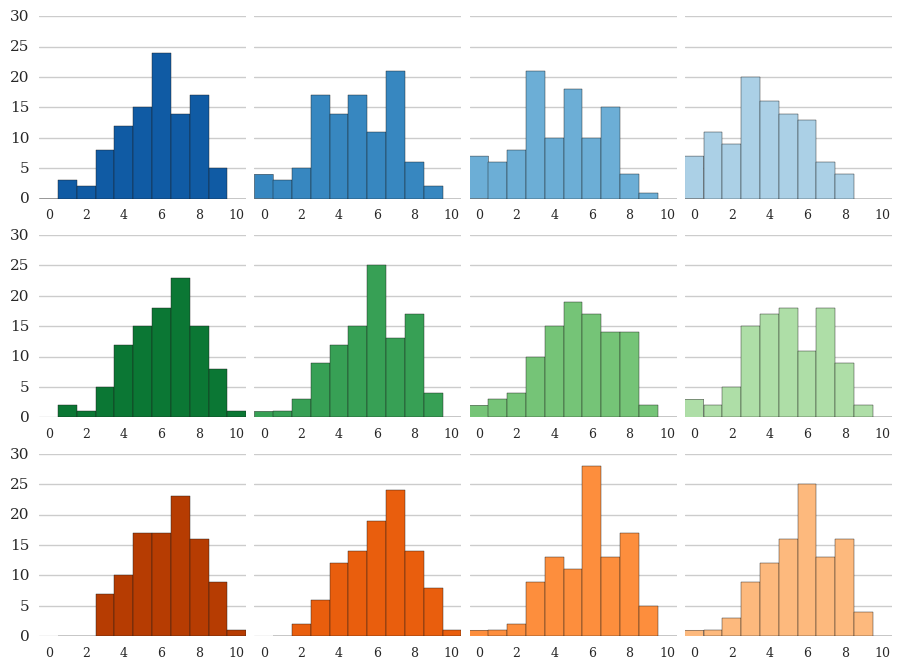

In [205]:
graficar_histogramas(riqueza_total, ylim=30)

### Survival threshold

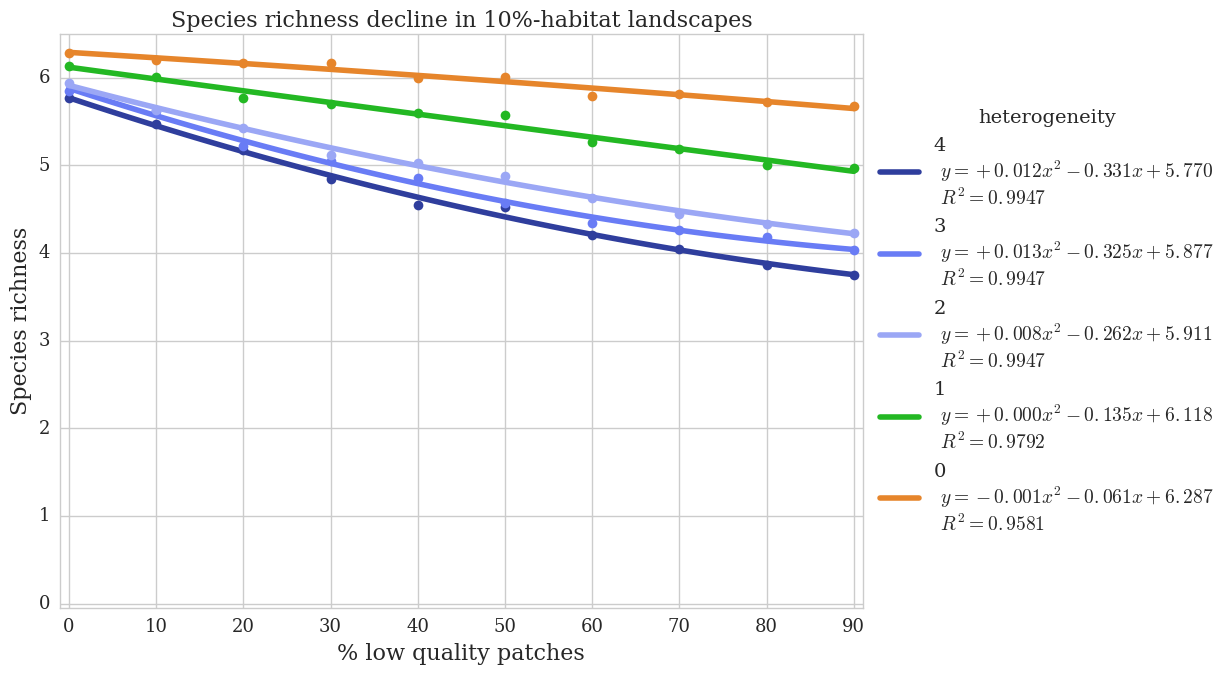

In [206]:
graficar('Species richness', riqueza_total_mean, riqueza_total_sd)

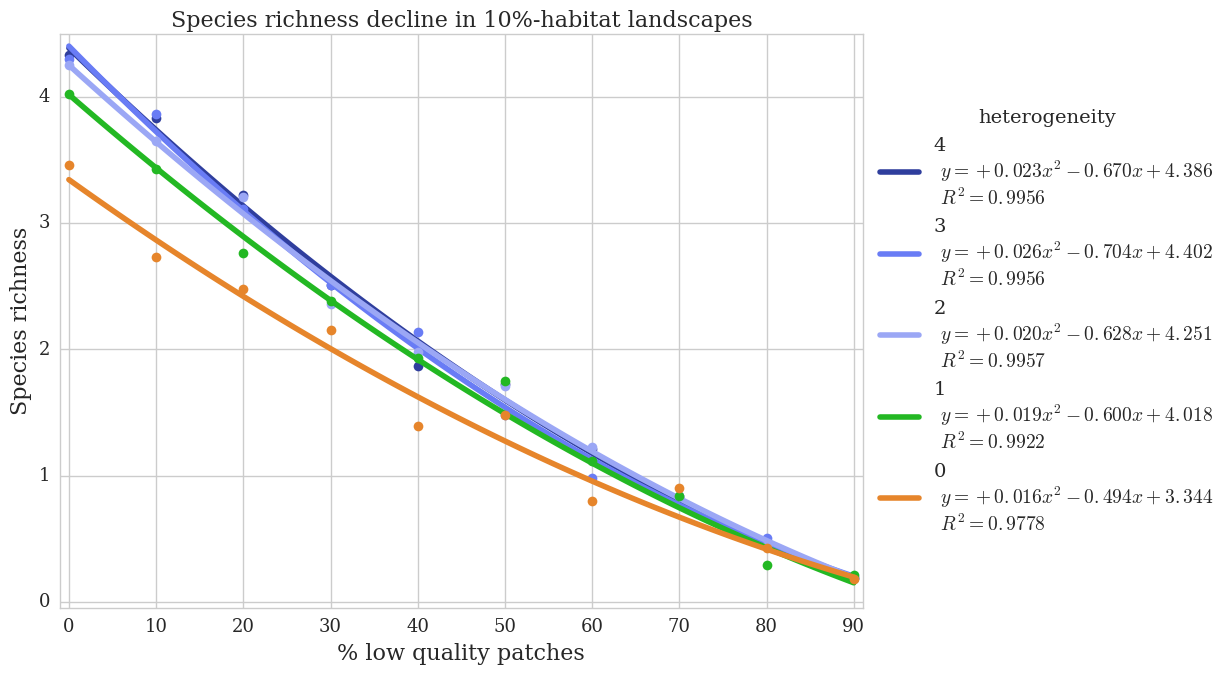

In [152]:
graficar('Species richness', riquezas_mean, riquezas_sd)

In [31]:
def graficar_umbral():
    het = 0
    thresholds = [0.01, 1, 30, 40, 50]
    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    colors = seaborn.cubehelix_palette(5, reverse=True, rot = 0.5, light=0.7)
    
    fig = plt.figure()
    
    for i, threshold in enumerate(thresholds):
        #r = calcular_riqueza(datos[het], paisajes[het], bio_min = threshold)[1]
        r = calcular_riquezatotal(datos[het], bio_min = threshold)[1]
        r_mean, r_sd, r_median = calcular_promedio(r)
        res = np.polyfit(xdata, r_mean, 2, w=1/r_sd)
        p = np.poly1d(res)
        r2 = 1 - ((np.sum((p(range(10)) - r_mean)**2)) / (np.sum((r_mean - np.mean(r_mean))**2)))
                
        label = '$y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                 float(p[2]), float(p[1]), float(p[0]), float(r2))
        
        plt.plot(x, p(x), lw = 4, color= colors[i], label='{} \n {}'.format(threshold, label)) #fit
        plt.plot(xdata, r_mean, 'o', color= colors[i]) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel('Species richness')
    plt.title("Richness decline in landscapes with \n 10% habitat, high heterogeneity")
    plt.legend(loc='center left', title="survival threshold", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

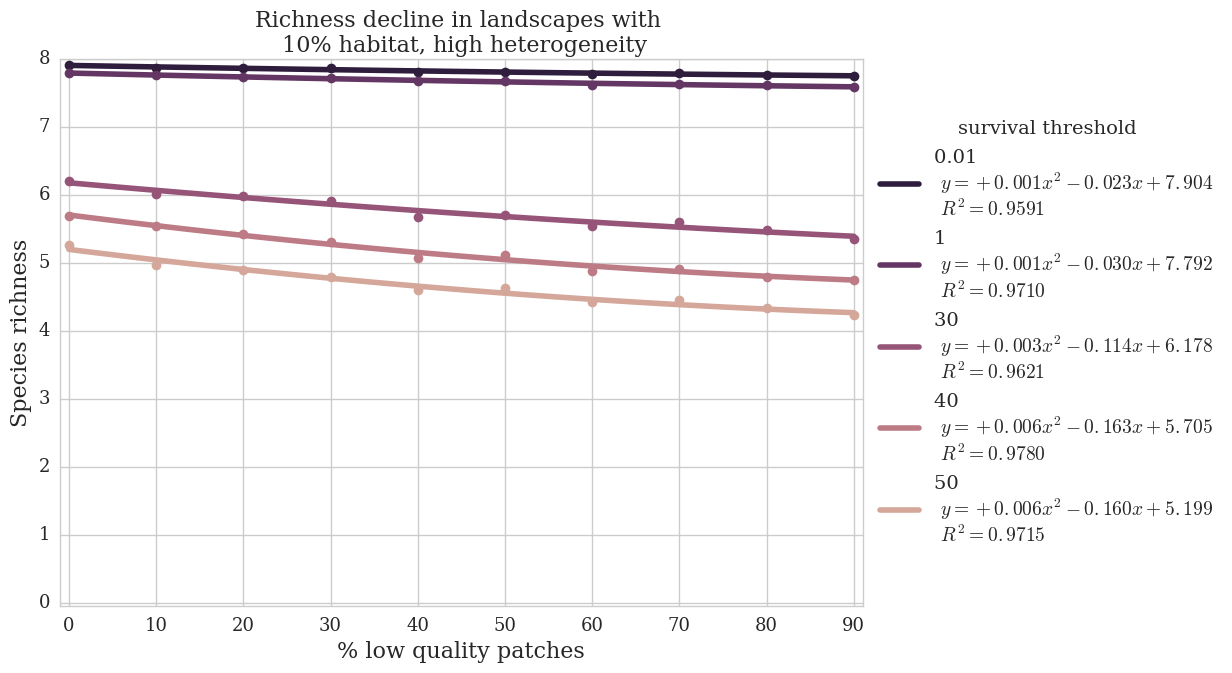

In [32]:
graficar_umbral()

### Biomass

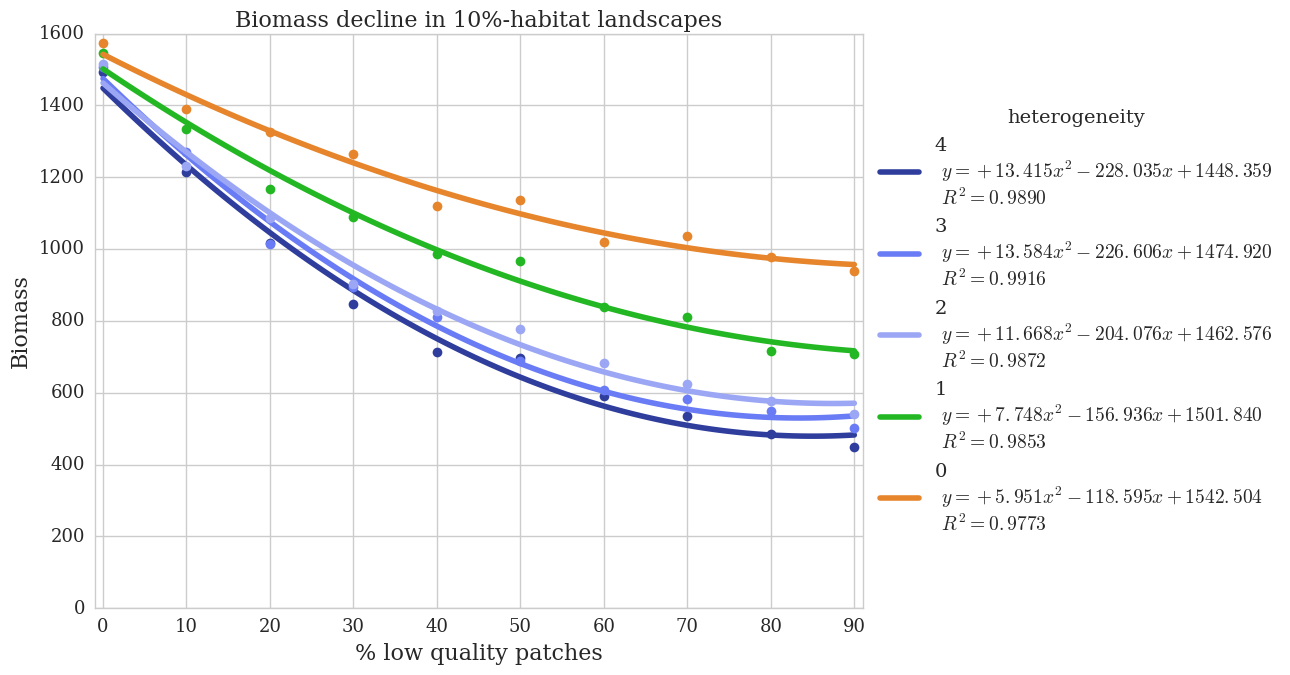

In [66]:
graficar('Biomass', biomasa_total_mean, biomasa_total_sd)

### Richness (considering area)

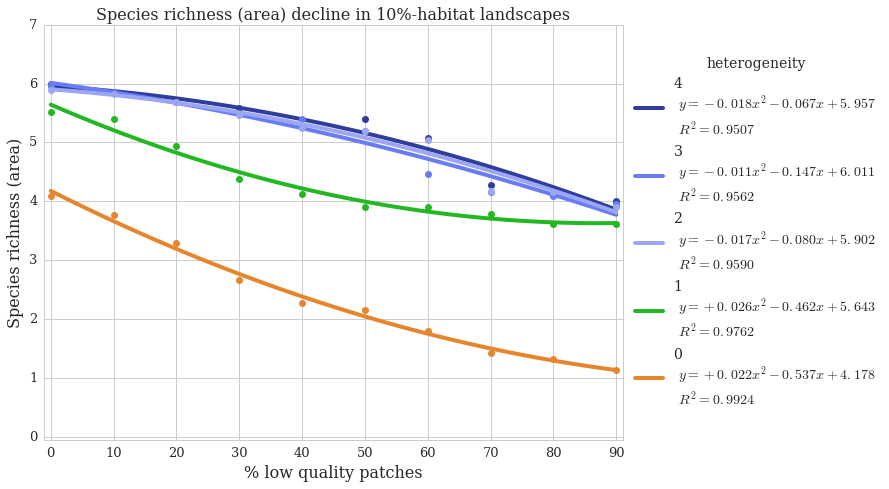

In [62]:
graficar('Species richness (area)', area_mean, area_sd)

## Identifying significant differences in richness

Note: shape of `np.array(biodiversity_measure)` is `[heterogeneity, communities, intensification]`.

### Do data distribute normally?

We use Shapiro-Wilk test. Null hypothesis is that data subsets came from a normally distributed population.

**Result:** Data subsets don't follow a normal distribution. 

In [32]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = np.array(riqueza_total)[het, :, i]
        
        pvalue = stats.shapiro(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.0032, ---NOT NORMAL---
H0, i1, p= 0.0011, ---NOT NORMAL---
H0, i2, p= 0.0039, ---NOT NORMAL---
H0, i3, p= 0.0043, ---NOT NORMAL---
H0, i4, p= 0.0063, ---NOT NORMAL---
H0, i5, p= 0.0058, ---NOT NORMAL---
H0, i6, p= 0.0012, ---NOT NORMAL---
H0, i7, p= 0.0050, ---NOT NORMAL---
H0, i8, p= 0.0009, ---NOT NORMAL---
H0, i9, p= 0.0014, ---NOT NORMAL---
H1, i0, p= 0.0040, ---NOT NORMAL---
H1, i1, p= 0.0037, ---NOT NORMAL---
H1, i2, p= 0.0029, ---NOT NORMAL---
H1, i3, p= 0.0008, ---NOT NORMAL---
H1, i4, p= 0.0007, ---NOT NORMAL---
H1, i5, p= 0.0015, ---NOT NORMAL---
H1, i6, p= 0.0027, ---NOT NORMAL---
H1, i7, p= 0.0023, ---NOT NORMAL---
H1, i8, p= 0.0032, ---NOT NORMAL---
H1, i9, p= 0.0017, ---NOT NORMAL---
H2, i0, p= 0.0035, ---NOT NORMAL---
H2, i1, p= 0.0010, ---NOT NORMAL---
H2, i2, p= 0.0009, ---NOT NORMAL---
H2, i3, p= 0.0026, ---NOT NORMAL---
H2, i4, p= 0.0012, ---NOT NORMAL---
H2, i5, p= 0.0014, ---NOT NORMAL---
H2, i6, p= 0.0036, ---NOT NORMAL---
H2, i7, p= 0.0048, ---NOT NO

However, using D'Agostino and Pearson's omnibus test, data subsets are normal. Again, null hypothesis is that data subsets came from a normally distributed population.

In [33]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = np.array(riqueza_total)[het, :, i]
        
        pvalue = stats.normaltest(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.3461, normal
H0, i1, p= 0.0442, ---NOT NORMAL---
H0, i2, p= 0.1393, normal
H0, i3, p= 0.2129, normal
H0, i4, p= 0.3287, normal
H0, i5, p= 0.3157, normal
H0, i6, p= 0.1810, normal
H0, i7, p= 0.2906, normal
H0, i8, p= 0.1330, normal
H0, i9, p= 0.2291, normal
H1, i0, p= 0.2222, normal
H1, i1, p= 0.1865, normal
H1, i2, p= 0.1728, normal
H1, i3, p= 0.1238, normal
H1, i4, p= 0.1909, normal
H1, i5, p= 0.1472, normal
H1, i6, p= 0.2061, normal
H1, i7, p= 0.1835, normal
H1, i8, p= 0.2234, normal
H1, i9, p= 0.1868, normal
H2, i0, p= 0.1791, normal
H2, i1, p= 0.1442, normal
H2, i2, p= 0.1927, normal
H2, i3, p= 0.1923, normal
H2, i4, p= 0.1371, normal
H2, i5, p= 0.1617, normal
H2, i6, p= 0.2595, normal
H2, i7, p= 0.3095, normal
H2, i8, p= 0.2301, normal
H2, i9, p= 0.1314, normal
H3, i0, p= 0.1800, normal
H3, i1, p= 0.1442, normal
H3, i2, p= 0.1663, normal
H3, i3, p= 0.1275, normal
H3, i4, p= 0.1918, normal
H3, i5, p= 0.2474, normal
H3, i6, p= 0.2229, normal
H3, i7, p= 0.2170, normal
H3

### Do data have the same variance?

We use Levene test, which does not assume normality. Null hypothesis is that population variances are equal. In particular, we want to know whether data subsets from all heterogeneity levels have the same variance at each intensification level.

**Result:** At each intensification level, richness from all heterogeneity levels has equal variance.

In [34]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riqueza_total)[0, :, i],
                          np.array(riqueza_total)[1, :, i],
                          np.array(riqueza_total)[2, :, i],
                          np.array(riqueza_total)[3, :, i],
                          np.array(riqueza_total)[4, :, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.9312, equal std
i1, pvalue=0.9977, equal std
i2, pvalue=0.9572, equal std
i3, pvalue=0.5783, equal std
i4, pvalue=0.3933, equal std
i5, pvalue=0.4424, equal std
i6, pvalue=0.2377, equal std
i7, pvalue=0.1784, equal std
i8, pvalue=0.1688, equal std
i9, pvalue=0.1014, equal std


for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(area)[0, :, i],
                          np.array(area)[1, :, i],
                          np.array(area)[2, :, i],
                          np.array(area)[3, :, i],
                          np.array(area)[4, :, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

We get the same results using Bartlett test.

In [35]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.bartlett(np.array(riqueza_total)[0, :, i],
                          np.array(riqueza_total)[1, :, i],
                          np.array(riqueza_total)[2, :, i],
                          np.array(riqueza_total)[3, :, i],
                          np.array(riqueza_total)[4, :, i],)[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.7801, equal std
i1, pvalue=0.9128, equal std
i2, pvalue=0.7932, equal std
i3, pvalue=0.4426, equal std
i4, pvalue=0.4861, equal std
i5, pvalue=0.4978, equal std
i6, pvalue=0.2576, equal std
i7, pvalue=0.2883, equal std
i8, pvalue=0.3081, equal std
i9, pvalue=0.2379, equal std


for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.bartlett(np.array(area)[0, :, i],
                          np.array(area)[1, :, i],
                          np.array(area)[2, :, i],
                          np.array(area)[3, :, i],
                          np.array(area)[4, :, i])[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

*Extra:* Do data from each heterogeneity level have same variance across the intensification gradient?

**Result:** Yes

In [36]:
for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riqueza_total)[het, :, 0],
                      np.array(riqueza_total)[het, :, 1],
                      np.array(riqueza_total)[het, :, 2],
                      np.array(riqueza_total)[het, :, 3],
                      np.array(riqueza_total)[het, :, 4],
                      np.array(riqueza_total)[het, :, 5],
                      np.array(riqueza_total)[het, :, 6],
                      np.array(riqueza_total)[het, :, 7],
                      np.array(riqueza_total)[het, :, 8],
                      np.array(riqueza_total)[het, :, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.4f}, {}'.format(het, pvalue, equal_std))

h0, pvalue=1.0000, equal std
h1, pvalue=0.9713, equal std
h2, pvalue=0.5880, equal std
h3, pvalue=0.4427, equal std
h4, pvalue=0.4296, equal std


for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(area)[het, :, 0],
                      np.array(area)[het, :, 1],
                      np.array(area)[het, :, 2],
                      np.array(area)[het, :, 3],
                      np.array(area)[het, :, 4],
                      np.array(area)[het, :, 5],
                      np.array(area)[het, :, 6],
                      np.array(area)[het, :, 7],
                      np.array(area)[het, :, 8],
                      np.array(area)[het, :, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.4f}, {}'.format(het, pvalue, equal_std))

### Differences between heterogeneity levels

We use Kruskal test to identify significant differences in biodiversity between heterogeneity levels at each level of intensification. Null hypothesis is that population medians are equal.

There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [52]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riqueza_total)[4, :, i],
                           np.array(riqueza_total)[3, :, i],
                           np.array(riqueza_total)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.7504, no difference
i1, pvalue=0.8914, no difference
i2, pvalue=0.7121, no difference
i3, pvalue=0.6623, no difference
i4, pvalue=0.5213, no difference
i5, pvalue=0.5809, no difference
i6, pvalue=0.6752, no difference
i7, pvalue=0.5311, no difference
i8, pvalue=0.4287, no difference
i9, pvalue=0.4291, no difference


# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(area)[4, :, i],
                           np.array(area)[3, :, i],
                           np.array(area)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

Given that data don't seem to differ significantly from normality, we can use ANOVA tests. In this case, null hyphotesis is that group means are equal. We get the same results: There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [53]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(riqueza_total)[4, :, i],
                           np.array(riqueza_total)[3, :, i],
                           np.array(riqueza_total)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.7526, no difference
i1, pvalue=0.9158, no difference
i2, pvalue=0.6524, no difference
i3, pvalue=0.7230, no difference
i4, pvalue=0.4917, no difference
i5, pvalue=0.5507, no difference
i6, pvalue=0.6234, no difference
i7, pvalue=0.4968, no difference
i8, pvalue=0.4340, no difference
i9, pvalue=0.4442, no difference


# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(area)[4, :, i],
                           np.array(area)[3, :, i],
                           np.array(area)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

Heterogeneity levels 4 (highest) and 0 (lowest) are significantly different at all intensification levels.

In [54]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riqueza_total)[4, :, i],
                           np.array(riqueza_total)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.1648, no difference
i1, pvalue=0.0527, no difference
i2, pvalue=0.0065, ---DIFFERENT---
i3, pvalue=0.0005, ---DIFFERENT---
i4, pvalue=0.0004, ---DIFFERENT---
i5, pvalue=0.0002, ---DIFFERENT---
i6, pvalue=0.0001, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(area)[4, :, i],
                           np.array(area)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

We get the same results using ANOVA.

In [55]:
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(riqueza_total)[4, :, i],
                            np.array(riqueza_total)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.1041, no difference
i1, pvalue=0.0327, ---DIFFERENT---
i2, pvalue=0.0023, ---DIFFERENT---
i3, pvalue=0.0002, ---DIFFERENT---
i4, pvalue=0.0001, ---DIFFERENT---
i5, pvalue=0.0001, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(area)[4, :, i],
                           np.array(area)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

At what intensification levels are heterogeneity levels 4, 1 and 0 different from each other? This is, at what intensification levels is het1 different from het4 and from het0?

In [56]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(riqueza_total)[4, :, i],
                               np.array(riqueza_total)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(riqueza_total)[0, :, i],
                               np.array(riqueza_total)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14= {:.4f}, pvalue_10= {:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14= 0.2248, pvalue_10= 0.8798, -
i1, pvalue_14= 0.1372, pvalue_10= 0.6512, -
i2, pvalue_14= 0.1317, pvalue_10= 0.2005, -
i3, pvalue_14= 0.0204, pvalue_10= 0.1865, -
i4, pvalue_14= 0.0062, pvalue_10= 0.3874, -
i5, pvalue_14= 0.0080, pvalue_10= 0.2463, -
i6, pvalue_14= 0.0086, pvalue_10= 0.1635, -
i7, pvalue_14= 0.0028, pvalue_10= 0.1088, -
i8, pvalue_14= 0.0040, pvalue_10= 0.0443, ---DIFFERENT---
i9, pvalue_14= 0.0012, pvalue_10= 0.0455, ---DIFFERENT---


# Area
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(area)[4, :, i],
                               np.array(area)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(area)[0, :, i],
                               np.array(area)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

When using ANOVA, the range where richness in heterogeneity levels 4, 1 and 0 is distinct increases to 20%-90% (except 80%).

In [57]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.f_oneway(np.array(riqueza_total)[4, :, i],
                               np.array(riqueza_total)[1, :, i])[1]
    
    pvalue_10 = stats.f_oneway(np.array(riqueza_total)[0, :, i],
                               np.array(riqueza_total)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.2031, pvalue_10=0.7533, -
i1, pvalue_14=0.1301, pvalue_10=0.5335, -
i2, pvalue_14=0.1026, pvalue_10=0.1476, -
i3, pvalue_14=0.0177, pvalue_10=0.1519, -
i4, pvalue_14=0.0034, pvalue_10=0.3433, -
i5, pvalue_14=0.0046, pvalue_10=0.2030, -
i6, pvalue_14=0.0055, pvalue_10=0.1580, -
i7, pvalue_14=0.0020, pvalue_10=0.0880, -
i8, pvalue_14=0.0026, pvalue_10=0.0394, ---DIFFERENT---
i9, pvalue_14=0.0008, pvalue_10=0.0437, ---DIFFERENT---


Using ANOVA, we get the same results for when species richness (constrained by area) is distinct in heterogeneity levels 4, 1 and 0.

# Area
for i in range(10):
    res = '-'
    pvalue_14 = stats.f_oneway(np.array(area)[4, :, i],
                               np.array(area)[1, :, i])[1]
    
    pvalue_10 = stats.f_oneway(np.array(area)[0, :, i],
                               np.array(area)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))